# NLP Albumentation with YELP Reviews

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import spacy
import seaborn as sns
import matplotlib.pyplot as plt
import gensim
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from nltk.cluster import KMeansClusterer

c:\Users\echemochek\anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


### Load Data

In [2]:
data = pd.read_csv("data/yelp.csv")
dataAug = pd.read_csv("data/yelp_augmented.csv")
dataSentiment = pd.read_csv("data/yelpSentiment.csv")

In [3]:
dataSentiment = dataSentiment[["text", "polarity"]]
dataAug = dataAug[["augmented"]]

In [4]:
data["text"] = data["text"].str.lower()
dataAug["augmented"] = dataAug["augmented"].str.lower()
dataSentiment["text"] = dataSentiment["text"].str.lower()

## Exploration

In [ ]:
# length of each review
data['text'].str.len().hist()

In [ ]:
# number of words in each review
data['text'].str.split().map(lambda x: len(x)).hist()

In [ ]:
# average word length in each review
data['text'].str.split().apply(lambda x : [len(i) for i in x]). map(lambda x: np.mean(x)).hist()

In [ ]:
# distribution of stopwords
stop = set(stopwords.words('english'))

corpus=[]
txt = data['text'].str.split()
txt = txt.values.tolist()
corpus=[word for i in txt for word in i]

from collections import defaultdict
dic = defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1

In [ ]:
# visualize most frequent stopwords
dic = dict(sorted(dic.items(), key=lambda item: item[1], reverse = True))
dic_subset = {key:value for key, value in dic.items() if value > 4000}

names = list(dic_subset.keys())
values = list(dic_subset.values())

plt.figure(figsize=(10,6)) 
plt.bar(range(len(dic_subset)), values, tick_label = names)
plt.title("Most frequent stopwords")
plt.xticks(rotation = 90)
plt.show()

In [ ]:
# most frequent non-stopwords

import collections
from collections import Counter

counter = Counter(corpus)
most = counter.most_common()

x, y= [], []
for word,count in most[:40]:
    if (word not in stop):
        x.append(word)
        y.append(count)
        
sns.barplot(x=y,y=x).set(title='Most frequent non-stopwords')

In [ ]:
# most frequent n-grams

def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) 
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:10]

In [ ]:
# bigrams and trigrams plot

def plotNgrams(df, colname, gram='bi'):
    import seaborn as sns

    # bigrams
    if gram=='bi':
        top_bi_grams = get_top_ngram(df[colname], n=2)
        x_bi,y_bi = map(list,zip(*top_bi_grams))
        plot = sns.barplot(x=y_bi, y=x_bi).set(title='Most frequent bigrams')

    # trigrams
    elif gram=='tri':
        top_tri_grams = get_top_ngram(data['text'], n=3)
        x_tri,y_tri = map(list,zip(*top_tri_grams))
        plot = sns.barplot(x=y_tri, y=x_tri).set(title='Most frequent trigrams')

    return plot

In [ ]:
plotNgrams(df=data, colname='text', gram='tri')

## Topic Modelling with pyLDAvis

In [ ]:
def preprocess_text(df):
    corpus=[]
    lem = WordNetLemmatizer()
    for txt in data['text']:
        words=[w for w in word_tokenize(txt) if (w not in stop)]
        
        words=[lem.lemmatize(w) for w in words if len(w)>2]
        
        corpus.append(words)
    return corpus

corpus = preprocess_text(txt)

In [ ]:
# BOW model
dic_bow = gensim.corpora.Dictionary(corpus)
bow_corpus = [dic_bow.doc2bow(doc) for doc in corpus]

In [ ]:
# LDA model
lda_model = gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 4, 
                                   id2word = dic_bow,                                    
                                   passes = 10,
                                   workers = 2)
lda_model.show_topics()

In [ ]:
# interacting with LDA output

#!pip install pyldavis

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

pyLDAvis.enable_notebook()

vis = gensimvis.prepare(lda_model, bow_corpus, dic_bow)
vis

## Wordcloud

In [ ]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

def show_wordcloud(data):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=100,
        max_font_size=30,
        scale=3,
        random_state=42)
   
    wordcloud = wordcloud.generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(corpus)

## Sentiment

In [8]:
from textblob import TextBlob

# polarity
def polarity(text):
    return TextBlob(text).sentiment.polarity


# sentiment classification
def sentiment(x):
    if x< -0.2:
        return 'neg'
    elif x>=-0.2 and x<=0.2:
        return 'neu'
    else:
        return 'pos'

[Text(0.5, 1.0, 'Distribution of Polarity Score')]

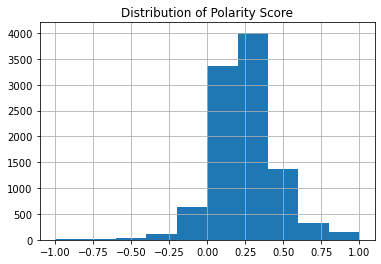

In [9]:
data['polarity_score']= data['text'].apply(lambda x : polarity(x))
data['polarity_score'].hist().set(title='Distribution of Polarity Score')

Text(0.5, 1.0, 'Polarity of Reviews')

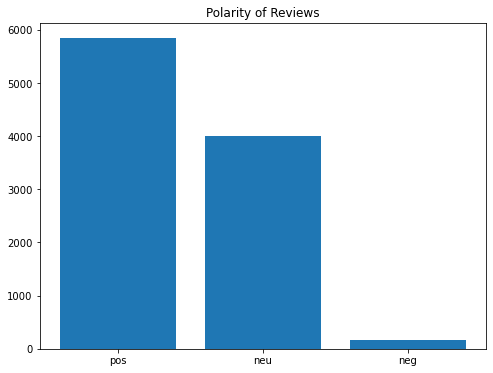

In [10]:
data['polarity'] = data['polarity_score'].map(lambda x: sentiment(x))

plt.figure(figsize=(8,6))
plt.bar(data.polarity.value_counts().index,
        data.polarity.value_counts()) 
plt.title("Polarity of Reviews")

In [ ]:
# data.to_csv("data/yelpSentiment.csv")

# NER

In [ ]:
# !python -m spacy download en_core_web_sm

In [ ]:
nlp = spacy.load("en_core_web_sm")

def ner(text):
    doc = nlp(text)
    return [X.label_ for X in doc.ents]

ent = data['text'].apply(lambda x : ner(x))
ent = [x for sub in ent for x in sub]

counter = Counter(ent)
count = counter.most_common()

In [ ]:
# entity frequencies visualization
x,y = map(list,zip(*count))
sns.barplot(x=y, y=x).set(title='Entity Classes in the Reviews')

In [ ]:
# we can then visualize token per entity

def ner(text,ent="ORG"):
    doc = nlp(text)
    return [X.text for X in doc.ents if X.label_ == ent]

In [ ]:
# a look at the date entities mentioned in the reviews
org = data['text'].apply(lambda x: ner(x, "DATE"))
org = [i for x in org for i in x]
counter = Counter(org)

x,y = map(list,zip(*counter.most_common(10)))
sns.barplot(y, x).set(title='Most Mentioned Date Entities')

In [ ]:
# a look at the organizations mentioned in the reviews
org = data['text'].apply(lambda x: ner(x, ent="ORG"))
org = [i for x in org for i in x]
counter = Counter(org)

x,y = map(list,zip(*counter.most_common(10)))
sns.barplot(y, x).set(title='Most Mentioned Organizations')

In [ ]:
# a look at the places mentioned in the reviews
org = data['text'].apply(lambda x: ner(x, "PERSON"))
org = [i for x in org for i in x]
counter = Counter(org)

x,y = map(list,zip(*counter.most_common(10)))
sns.barplot(y, x).set(title='Most Mentioned People')

## POS Exploration

In [ ]:
def pos(text):
    pos=nltk.pos_tag(word_tokenize(text))
    pos=list(map(list,zip(*pos)))[1]
    return pos

tags = data['text'].apply(lambda x : pos(x))
tags=[x for l in tags for x in l]
counter = Counter(tags)

x,y = list(map(list,zip(*counter.most_common(7))))
sns.barplot(x=y,y=x)

- Noun (NN)
- Verb (VB)
- Adjective (JJ)
- Adverb(RB)
- Preposition (IN)
- Conjunction (CC)
- Pronoun(PRP)
- Interjection (INT)

In [ ]:
# drilling down even further: looking at NN
def get_adjs(text):
    adj=[]
    pos = nltk.pos_tag(word_tokenize(text))
    for word,tag in pos:
        if tag=='NN':
            adj.append(word)
    return adj


words = data['text'].apply(lambda x : get_adjs(x))
words = [x for l in words for x in l]
counter = Counter(words)

x,y = list(map(list,zip(*counter.most_common(7))))
sns.barplot(x=y, y=x)

### Embeddings with BERT (Hugging Face's transformer architecture)

In [ ]:
'''
# be sure to download the pretrained transformer via the spaCy pipeline
# !spacy download en_core_web_trf
# !pip install spacy-transformers

import en_core_web_trf

txt = "The quick brown fox jumps over the lazy dog"

#Load the bert model
nlp = en_core_web_trf.load()#spacy.load("en_core_web_trf", disable=["tagger", "attribute_ruler", "lemmatizer"])

# get sentence embeddings from input text
def get_embeddings(text):
    return nlp(text).
    
    # Generating sentence embedding from the text
# data['embeddings'] = data['text'].apply(get_embeddings)

df = get_embeddings(txt)

# it takes time to run BERT so its better to save the updated data for future use
# data.to_csv("data/yelp_embeddings.csv")

# Transformer outputs sequences longer than the maximum length for the model (537 > 512). We will truncate the output.

# df = pd.read_csv("data/yelp_embeddings.csv")

'''

In [13]:
dataAug["polarity"] = dataSentiment["polarity"]
dataAug.rename(columns={"augmented": "text"}, inplace = True)

merged_df = dataSentiment.append(dataAug, ignore_index=True)

## Base Clustering Algorithm

In [ ]:
'''
## Import libraries
def clustering_question(data, NUM_CLUSTERS = 15):

    sentences = data['text']

    X = np.array(data['emb'].tolist())

    kclusterer = KMeansClusterer(
        NUM_CLUSTERS, distance=nltk.cluster.util.cosine_distance,
        repeats=25,avoid_empty_clusters=True)

    assigned_clusters = kclusterer.cluster(X, assign_clusters=True)

    data['cluster'] = pd.Series(assigned_clusters, index=data.index)
    data['centroid'] = data['cluster'].apply(lambda x: kclusterer.means()[x])

    return data, assigned_clusters

def distance_from_centroid(row):
    # type of emb and centroid is different, hence using tolist below
    return distance_matrix([row['emb']], [row['centroid'].tolist()])[0][0]

# Compute centroid distance to the data
data['distance_from_centroid'] = data.apply(distance_from_centroid, axis=1)

# df = dataSentiment.copy()
df = data.copy()

'''

## Base Classifier Algorithm

In [14]:
# label encoding the classes
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

encoder.fit(dataSentiment['polarity'])

dataSentiment['category'] = encoder.transform(dataSentiment['polarity'])
merged_df['category'] = encoder.transform(merged_df['polarity'])

In [15]:
# train-test split
def splitStep(df=dataSentiment, X="text", y="category", test_size=0.2, random_state=42):
    from sklearn.model_selection import train_test_split

    xtrain, xtest, ytrain, ytest = train_test_split(dataSentiment[X], dataSentiment[y], stratify=dataSentiment[y], test_size=test_size)

    return xtrain, xtest, ytrain, ytest


# word vectorizer
def w2v(x, num_features=100): # xtrain & xtest will be accessed from the vectorizeStep (ignore warning)
    import numpy as np
    from gensim.models import Word2Vec

    wordvec = Word2Vec(x, window=8, min_count=2, sample=1e-3, sg=1, workers=8) 
    vocab = set(wordvec.wv.index_to_key)
    num_features = num_features

    def average_word_vectors(tokens, model, vocabulary, num_features):
        feature_vector = np.zeros((num_features,), dtype="float64")
        ntokens = 0.
        for t in tokens:
            if t in vocabulary: 
                ntokens = ntokens + 1.
                feature_vector = np.add(feature_vector, model.wv[t])
        if ntokens:
            feature_vector = np.divide(feature_vector, ntokens)
        return feature_vector

    xTransformed = np.array([average_word_vectors(sent_tokens, wordvec, vocab, num_features) 
                    for sent_tokens in x]) 
    return xTransformed


# document vectorizer
def d2v(x):
    from gensim.models.doc2vec import Doc2Vec, TaggedDocument

    docs = [TaggedDocument(doc, [i]) for i, doc in enumerate(x)]
    docvec = Doc2Vec(vector_size=100, window=3, min_count=4, workers=4, epochs=40)
    docvec.build_vocab(docs)
    docvec.train(docs, total_examples=docvec.corpus_count, epochs=docvec.epochs)

    from gensim.utils import simple_preprocess
    xTokenized = [simple_preprocess(h) for h in x]

    xTransformed = [docvec.infer_vector(i) for i in xTokenized]

    return xTransformed


# transform data (options: TF-IDF, TF-IDF ngrams, word2vec, doc2vec)
def vectorizeStep(inputData, fittingData=data.text, outputFormat="tfidf"):
    
    # TF-IDF input
    if outputFormat == "tfidf":
        from sklearn.feature_extraction.text import TfidfVectorizer
        vectorizer = TfidfVectorizer(
                            strip_accents="unicode", lowercase=True, analyzer='word', 
                            stop_words='english', max_df=0.95, min_df=0.05, max_features=500
                                )
        vectorizer.fit(fittingData)
        
        transformedData = vectorizer.transform(inputData)
    
    # TF-IDF ngrams input
    elif outputFormat == "ngrams":
        from sklearn.feature_extraction.text import TfidfVectorizer
        vectorizer = TfidfVectorizer(
                            strip_accents="unicode", lowercase=True, analyzer='word', ngram_range=(2,3), 
                            max_df=0.95, min_df=0.05, max_features=500
                            )
        vectorizer.fit(fittingData)
        
        transformedData = vectorizer.transform(inputData)

    # word vector input
    elif outputFormat == "word2vec":
        transformedData = w2v(inputData)

    # document vector input
    elif outputFormat == "doc2vec":
        transformedData = d2v(inputData)
        
    return transformedData


# train models
def trainStep(classifier: str, x_input, y_input):
    
    # import GridSearchCV
    from sklearn.model_selection import GridSearchCV

    # create a SVC model using GridSearchCV
    if classifier == "svc":
        
        # import SVC
        from sklearn.svm import SVC

        param_grid = {
                        'C': [0.1, 1, 10, 100, 1000],'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                        'kernel': ['linear', 'rbf', 'sigmoid']} 
        

        
        model = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)

    # create an XGBoost model
    elif classifier == "xgboost":
        import xgboost
        model = xgboost.XGBClassifier()

    # create a knn model
    elif classifier == "knn":

        # import KNN
        from sklearn.neighbors import KNeighborsClassifier

        k_range = list(range(1, 31))
        param_grid = dict(n_neighbors=k_range)
        
        model = GridSearchCV(KNeighborsClassifier(), param_grid, cv=10, scoring='accuracy')
    
    m = model.fit(x_input, y_input)
    
    return m


# predict on the xtest 
def predictStep(trainedModel, x_input):
    predictions = trainedModel.predict(x_input)
    return predictions

# evaluate on ytest 
def evaluateStep(ytrue, ypred):
    from sklearn.metrics import precision_recall_fscore_support as score
    from sklearn.metrics import accuracy_score
    
    precision,recall,fscore,_=score(ytrue,ypred, average='macro')
    accuracy = accuracy_score(ytrue,ypred)

    return round(precision,4), round(recall,4), round(fscore,4), round(accuracy,4) #,roc_auc
    

In [31]:
# dictionary to store f1 scores of different models
f1ScoreMetrics = {'xgboost': [],'knn': []}

# dictionary to store accuracy scores of different models
accuracyScoreMetrics = {'xgboost': [],'knn': []}

In [32]:
# train-test split the data 
xTrn, xTst, yTrn, yTst = splitStep(df=data, X="text", y="category")

# models and inputs
modelList = ['xgboost', 'knn']
dataFormats = ['tfidf', 'ngrams']
trainedModels = [] # to store the models we train to use later

# fit model, train on training data, test on the testing set, append scores to dictionaries
for model in modelList:
    for dataFormat in dataFormats:

        # vectorize
        xtrainVectorized = vectorizeStep(xTrn, outputFormat=dataFormat)
        xtestVectorized = vectorizeStep(xTst, outputFormat=dataFormat)

        # train
        trainedModel = trainStep(model, xtrainVectorized, yTrn)

        # predict
        ypreds = predictStep(trainedModel, xtestVectorized)

        # evaluate
        metrics = evaluateStep(yTst, ypreds)

        # append trained models to a list and metrics to a dictionary
        trainedModels.append(trainedModel) 
        f1ScoreMetrics[model].append(metrics[2])
        accuracyScoreMetrics[model].append(metrics[3])

c:\Users\echemochek\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:55:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\Users\echemochek\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:55:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\Users\echemochek\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [33]:
# function for highlighting best model
def highlight_cells(val):
    color = 'yellow' if val == maxVal else ''
    return 'background-color: {}'.format(color)

In [34]:
# display f1 scores in a formatted dataframe
f1_df = pd.DataFrame.from_dict(f1ScoreMetrics)
f1_df.set_index([pd.Index(dataFormats)], inplace=True)

maxVal = f1_df.max().max()
f1_df.style.applymap(highlight_cells)

,xgboost,knn
tfidf,0.524900,0.412600
ngrams,0.396800,0.361400


In [35]:
# display recall scores in a formatted dataframe
accuracy_df = pd.DataFrame.from_dict(accuracyScoreMetrics)
accuracy_df.set_index([pd.Index(dataFormats)], inplace=True)

maxVal = accuracy_df.max().max()
accuracy_df.style.applymap(highlight_cells)

,xgboost,knn
tfidf,0.744500,0.602000
ngrams,0.622000,0.591000


In [ ]:
# the winning model is stored in the trainedModels list in index 4
winningModel = trainedModels[0]
winningModel

### Now use the model on augmented data

In [ ]:
df_albumentation = pd.read_csv("data/yelp_augmented_syn_ant_5K_only.csv")
df_albumentation.head()

In [ ]:
# let us create on large dataset! 
df_full = df_albumentation['text']\
            .append(df_albumentation['augmented'])\
                .append(df_albumentation['syn_augmented'])\
                    .append(df_albumentation['ant_augmented'])\
                        .reset_index(drop=True)

# create a new dataframe with the same name from the data
df_full = pd.DataFrame(data=df_full, columns=['text'], dtype=str) # this new dataframe has 20000 observations.

In [ ]:
'''
creating labels (sentiment for this dataset using the defined method in earlier steps
we do this instead of using labels from the parent column because the albumentation may 
have changed sentiments for some observations
'''
df_full['polarity_score']= df_full['text'].apply(lambda x : polarity(str(x)))
df_full['polarity'] = df_full['polarity_score'].map(lambda x: sentiment(x))

# we drop any potential duplicates - albumentation is not perfect
df_full.drop_duplicates(inplace=True)

# save dataframe with specific columns as new dataset so we can easily load it next time
# df_full[['text', 'polarity']].to_csv("data/yelpAugmentedFinal.csv")

In [20]:
# load the data with final data
df = pd.read_csv("data/yelpAugmentedFinal.csv")

In [ ]:
# dictionary to store f1 scores of different models
f1ScoreMetricsAug = {'xgboost': []}

# dictionary to store accuracy scores of different models
accuracyScoreMetricsAug = {'xgboost': []}

# drop any null values
df.dropna(inplace=True)

# save as training
xTrnAug = df["text"]
yTrnAug = df["polarity"]


# vectorize
xtrainVectorizedAug = vectorizeStep(xTrnAug, fittingData=df.text)

#xtestVectorized = vectorizeStep(xTst, outputFormat="tfidf")

In [25]:
# drop null values
df.dropna(inplace=True)

# label encode and add new column
df['category'] = encoder.transform(df['polarity'])

# save as training
xTrnAug = df["text"]
yTrnAug = df['category']


# models and inputs
modelList = ['xgboost', 'knn']
dataFormats = ['tfidf', 'ngrams']
trainedModelsAug = [] # to store the models we train to use later

# fit model, train on training data, test on the testing set, append scores to dictionaries
for model in modelList:
    for dataFormat in dataFormats:

        # vectorize
        xtrainVectorized = vectorizeStep(xTrnAug, outputFormat=dataFormat)
        xtestVectorized = vectorizeStep(xTst, outputFormat=dataFormat)

        # train
        trainedModel = trainStep(model, xtrainVectorized, yTrnAug)

        # predict
        ypreds = predictStep(trainedModel, xtestVectorized)

        # evaluate
        metrics = evaluateStep(yTst, ypreds)

        # append trained models to a list and metrics to a dictionary
        trainedModelsAug.append(trainedModel) 
        f1ScoreMetricsAug[model].append(metrics[2])
        accuracyScoreMetricsAug[model].append(metrics[3])

c:\Users\echemochek\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:38:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\Users\echemochek\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:39:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\Users\echemochek\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [29]:
# display f1 scores in a formatted dataframe
f1_df = pd.DataFrame.from_dict(f1ScoreMetrics)
f1_df.set_index([pd.Index(dataFormats)], inplace=True)

maxVal = f1_df.max().max()
f1_df.style.applymap(highlight_cells)

,xgboost,knn
tfidf,0.738900,0.636100
ngrams,0.479400,0.573700


In [30]:
# display recall scores in a formatted dataframe
accuracy_df = pd.DataFrame.from_dict(accuracyScoreMetrics)
accuracy_df.set_index([pd.Index(dataFormats)], inplace=True)

maxVal = accuracy_df.max().max()
accuracy_df.style.applymap(highlight_cells)

,xgboost,knn
tfidf,0.848500,0.760500
ngrams,0.717500,0.733000
